In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm

from pathlib import Path
import glob
import os
#import os
#import zipfile

import epiweeks

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import geopandas as gpd

pd.set_option('display.max_columns', 20)  # or any reasonable number


# Load data

In [2]:
mun_new = list(Path('/opt/storage/refined/aesop/visualization/')
               .glob('aesop_*_mun_new.parquet'))

aesop_mun_new = max(mun_new, key=lambda x: x.stat().st_ctime)

df = pd.read_parquet(aesop_mun_new)

ibp = pd.read_csv('/opt/storage/raw/aesop/visualization/files_genomic_sample/data-cidacs_ipb_municipios.csv')

viz_muni_count = pd.read_csv('/opt/storage/raw/aesop/visualization/count_municipios_vizinhos.csv')

folder_path = "/opt/storage/refined/aesop/visualization/cover_muni"
files = glob.glob(os.path.join(folder_path, "*.parquet"))

#df_list = [pd.read_parquet(file) for file in files]

df_list = []

for file in files:
    data = pd.read_parquet(file)
    data['source_file'] = os.path.basename(file)
    df_list.append(data)

cover = pd.concat(df_list, ignore_index=True)

In [3]:
#viz_muni = pd.read_csv('/opt/storage/raw/aesop/visualization/municipios_limitrofes_ibge.csv')

In [4]:
cover = cover.assign(co_ibge = cover.cod_ibge_muni.astype(str).str[0:6].astype(int),
                    year_week = cover.source_file.astype(str).str[11:18])

cover = cover[['co_ibge', 'year_week','ones', 'per']]

df['co_ibge'] = df['co_ibge'].astype(str)
cover['co_ibge'] = cover['co_ibge'].astype(str)

df['year_week'] = df['year_week'].astype(str)
cover['year_week'] = cover['year_week'].astype(str)

merged = df.merge(cover, on=['co_ibge', 'year_week'], how='left')

viz_muni_count = viz_muni_count.assign(co_ibge = viz_muni_count.codigo_ibge_municipio.astype(str).str[0:6].astype(int))

viz_muni_count = viz_muni_count[['co_ibge','num_municpios_vizinhos']]

viz_muni_count['co_ibge'] = viz_muni_count['co_ibge'].astype(str)

merged = merged.merge(viz_muni_count, on=['co_ibge'], how='left')

ibp = ibp[['ip_cd_m','ip_vl_n']]

ibp = ibp.assign(co_ibge = ibp.ip_cd_m.astype(str).str[0:6])

ibp = ibp[['co_ibge','ip_vl_n']]

merged = merged.merge(ibp, on=['co_ibge'], how='left')

# Select variables from mun_new that are indicatores to increase the risk of warning in a municipality

In [5]:
lst = ['co_uf',
       'nm_uf',
       'sigla_uf',
       'co_ibge',
       'co_ibge7',
       'nm_municipio',
       'epiyear',
       'epiweek',
       'year_week',
       'epidemi_cal_start',
       'epidemi_cal_end',
       'year_week_ts',
       'sinal_aesop_ivas',
       'sinal_otc_ivas',
       'sinal_ens_ivas',
       'perc_missing',
       'perc_completude',
       'diff_2w',
       'diff_3w',
       'sum_miss',
       'completude',
       'tempestividade',
       'dqi',
       'prob_gro_trend_ivas',
       'alerta_vizinho',
       'sinais_vizinhos',
       'num_municpios_vizinhos',
       'ones',
       'per',
       'ip_vl_n'
       ]

data = merged[lst]

In [6]:
data = data[data.year_week >= '2023-42']

In [7]:
data = data.rename(columns = { 'sinal_aesop_ivas': 'aviso_aesop_ivas',
                              'sinal_otc_ivas':'aviso_pip_ivas',
                               'sinal_ens_ivas': 'aviso_aps_ivas',
                     'alerta_vizinho': 'vizinho_com_aviso', 
                       'sinais_vizinhos': 'num_viz_aviso',
                      'ones': 'num_paths_covered',
                      'per':'per_mob_coverage',
                      'ip_vl_n':'privacao'})




# Prepare data to run the model

In [8]:
data['dqi'] = data['dqi'].replace({'Apto': 1, 'Não Apto': 0}).fillna(0)

data['num_paths_covered'] = data['num_paths_covered'].fillna(0)

data['per_mob_coverage'] = data['per_mob_coverage'].fillna(0)

data['privacao'] = data['privacao'].fillna(0)

data['num_paths_covered'] = data['num_paths_covered'].fillna(0)

data['aviso_pip_ivas'] = data['aviso_pip_ivas'].fillna(0)

data['vizinho_com_aviso'] = data['vizinho_com_aviso'].fillna(0)

data['num_viz_aviso'] = data['num_viz_aviso'].fillna(0)

data['prob_gro_trend_ivas'] = data['prob_gro_trend_ivas'].fillna(0)

In [9]:
data = data.assign(aviso_aesop_ivas = data.aviso_aesop_ivas.astype(int),
                   aviso_pip_ivas = data.aviso_pip_ivas.astype(int),
                   aviso_aps_ivas = data.aviso_aps_ivas.astype(int),
                   vizinho_com_aviso = data.vizinho_com_aviso.astype(int),
                   num_viz_aviso = data.num_viz_aviso.astype(int),
                   num_paths_covered = data.num_paths_covered.astype(int)
                  )                            

In [10]:
lst = []

for code in data.co_ibge.unique():
    
    set_muni = data[data.co_ibge == code]


    set_muni = set_muni.assign(aviso_pip_ivas_lag_1 = set_muni['aviso_pip_ivas'].shift(1).fillna(0).astype(int),
                               aviso_pip_ivas_lag_2 = set_muni['aviso_pip_ivas'].shift(2).fillna(0).astype(int),
                               aviso_pip_ivas_lag_3 = set_muni['aviso_pip_ivas'].shift(3).fillna(0).astype(int),
                               aviso_pip_ivas_lag_4 = set_muni['aviso_pip_ivas'].shift(4).fillna(0).astype(int),
                               aviso_aps_ivas_lag_1 = set_muni['aviso_aps_ivas'].shift(1).fillna(0).astype(int),
                               aviso_aps_ivas_lag_2 = set_muni['aviso_aps_ivas'].shift(2).fillna(0).astype(int),
                               aviso_aps_ivas_lag_3 = set_muni['aviso_aps_ivas'].shift(3).fillna(0).astype(int),
                  )

    lst.append(set_muni)

In [11]:
data = pd.concat(lst)

In [12]:
#data.to_parquet("/home/juliane.oliveira/workspace/Data/data_for_class.parquet", index=False, engine="pyarrow")

In [13]:
lst = []

for code in data.co_ibge.unique():

    #print(f"Processing municipality: {code}")
    
    set_muni = data[data.co_ibge == code].copy() 

    # Some cities may not have issued a warning
    if set_muni['aviso_aesop_ivas'].sum() == 0:
        set_muni['aviso_aesop_ivas'] = (set_muni['prob_gro_trend_ivas'] > 0.90).astype(int)
    else:
        pass 

    # Define features and target
    feature_cols = [
        'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
        'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3',
        'dqi', 'prob_gro_trend_ivas', 
        'num_viz_aviso', 'per_mob_coverage'
    ]

    X = set_muni[feature_cols]
    y = set_muni['aviso_aesop_ivas']

    # check if we have enough data
    #if len(set_muni) < 5 or y.nunique() < 2:
    #    print(f"Skipping {code}: not enough data or no variation in target.")
    #    continue

    # Fit model
    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X, y)

    # Predict and attach results
    y_pred = clf.predict(X)
    risk_probs = clf.predict_proba(X)[:, 1]

    set_muni['risk_probs_time'] = risk_probs
    set_muni['aviso_aesop_pred_time'] = y_pred

    lst.append(set_muni)


In [14]:
final_result = pd.concat(lst)

In [138]:
#set_muni = final_result[final_result.co_ibge == '355030']

#set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])

#plt.figure(figsize=(12, 6))
#plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_probs'],
#         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

#plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
#            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_probs'],
#            color='red', label='Warning', zorder=3)

#plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
#plt.xticks(rotation=45)
#plt.title('Lollipop Chart: Risk Probabilities & Warnings')
#plt.xlabel('Epidemiological week')
#plt.ylabel('Risk Probability')
#plt.legend()
#plt.tight_layout()
#plt.grid(False)
#plt.show()


# Second approach

In [15]:
lst = []

for date in final_result.year_week.unique():

    data = final_result[final_result.year_week == date].copy()

    # Define features and target
    feature_cols = [
        'dqi', 'prob_gro_trend_ivas', 'privacao',
        'num_viz_aviso', 'num_paths_covered' 
    ]  #'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
        #'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3','per_mob_coverage'

    X = data[feature_cols]
    y = data['aviso_aesop_ivas']

    # check if we have enough data
    #if len(set_muni) < 5 or y.nunique() < 2:
    #    print(f"Skipping {code}: not enough data or no variation in target.")
    #    continue

    # Fit model

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X, y)

    # Predict and attach results
    y_pred = clf.predict(X)
    risk_probs = clf.predict_proba(X)[:, 1]

    data['risk_probs_space'] = risk_probs
    data['aviso_aesop_pred_space'] = y_pred

    lst.append(data)


In [16]:
final_result2 = pd.concat(lst)

In [25]:
final_result2 = final_result2.assign(risk_prob_com = final_result2['risk_probs_time']*final_result2['risk_probs_space'])

In [38]:
final_result2

,co_uf,nm_uf,sigla_uf,co_ibge,co_ibge7,nm_municipio,epiyear,epiweek,year_week,epidemi_cal_start,...,aviso_pip_ivas_lag_3,aviso_pip_ivas_lag_4,aviso_aps_ivas_lag_1,aviso_aps_ivas_lag_2,aviso_aps_ivas_lag_3,risk_probs_time,aviso_aesop_pred_time,risk_probs_space,aviso_aesop_pred_space,risk_prob_com
354,11,Rondônia,RO,110001,1100015,Alta Floresta D'Oeste,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.822495,1,5.013881e-01,1,4.123894e-01
799,11,Rondônia,RO,110002,1100023,Ariquemes,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.680543,1,5.603662e-01,1,3.813533e-01
1244,11,Rondônia,RO,110003,1100031,Cabixi,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.764138,1,5.123386e-01,1,3.914975e-01
1689,11,Rondônia,RO,110004,1100049,Cacoal,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.841055,1,4.727928e-01,0,3.976446e-01
2134,11,Rondônia,RO,110005,1100056,Cerejeiras,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.433049,0,5.913038e-01,1,2.560634e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476869,52,Goiás,GO,522200,5222005,Vianópolis,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.117533,0,1.025547e-01,0,1.205360e-02
2477314,52,Goiás,GO,522205,5222054,Vicentinópolis,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.161932,0,4.446502e-02,0,7.200311e-03
2477759,52,Goiás,GO,522220,5222203,Vila Boa,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.467610,0,8.494414e-01,1,3.972069e-01
2478204,52,Goiás,GO,522230,5222302,Vila Propício,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.054339,0,8.044733e-02,0,4.371448e-03


In [35]:
#final_result2.risk_prob_com.describe()

In [36]:
#final_result2[final_result2.risk_prob_com >= 0.9][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [37]:
#final_result2[(final_result2.year_week == '2025-28') & (final_result2.risk_prob_com >= 0.6)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [21]:
#dta = final_result2[(final_result2.risk_probs_time >= 0.5) & (final_result2.risk_probs_space >= 0.9)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space']]

In [142]:
#print(classification_report(y, y_pred))

In [22]:
#data[(data.risk_probs >= 0.9) & (data.aviso_aesop_ivas == 1)][['nm_municipio',
#        'year_week',  'aviso_aesop_ivas', 
#        'dqi', 'prob_gro_trend_ivas', 'privacao',
#        'num_viz_aviso', 'num_paths_covered', 'risk_probs',
#       'aviso_aesop_pred']]

In [121]:
# --- Load shapefile of Brazilian municipalities ---

#gdf = gpd.read_file("/opt/storage/raw/aesop/visualization/shape_file_muni/BR_Municipios_2022.shp")  
# --- Merge risk data with geodata ---
#gdf = gdf.assign(co_ibge7 = gdf['CD_MUN'].astype(str))  # Standard IBGE code column
#data = data.assign(co_ibge7 = data['co_ibge7'].astype(str))
#merged = gdf.merge(data[['co_ibge7', 'aviso_aesop_ivas', 'risk_probs']], on="co_ibge7", how="left")

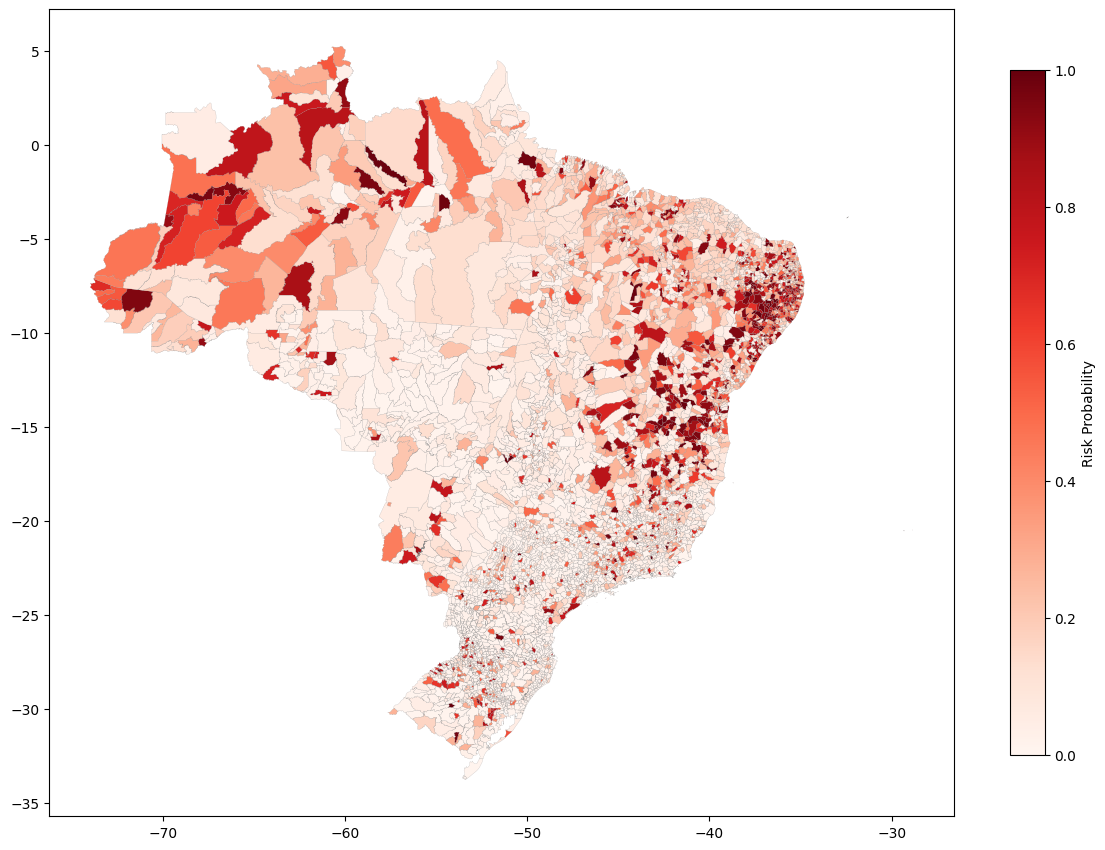

In [122]:
# --- Plotting ---
#fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# 1. Plot all municipalities, coloring by risk
#merged.plot(
#    column='risk_probs',
 #   cmap='Reds',
 #  linewidth=0.1,
#    edgecolor='grey',
 #   legend=True,
 #   vmin=0,                # Set the color scale min
  #  vmax=1,                # Set the color scale max
 #   legend_kwds={
 #       'label': "Risk Probability",
 #       'shrink': 0.5,     # Reduce height of the colorbar (0.0 to 1.0)
 #       'orientation': 'vertical'
 #   },
 #   ax=ax
#)

# 2. Highlight municipalities with aviso_aesop_ivas == 1
#pins = merged[merged['aviso_aesop_ivas'] == 1]
#pins.plot(ax=ax, color='blue', markersize=5, marker='o', label='Aviso AESOP')


# 3. Customize
#ax.set_title("Brazilian Municipalities: Risk Levels and AESOP Warnings", fontsize=14)
#ax.axis('off')
#plt.legend(loc='lower left')

#plt.tight_layout()
#plt.show()
